In [1]:
#@title Imports 
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import tjy_udf as tjy
print("tjy_udf: ", list(filter(lambda x: '__' not in x, dir(tjy)))) # Print contained functions
mpl.rc_file('tjy.mplstyle')

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)
DISPLAY_SORTED = True
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib import ticker
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from matplotlib import animation, rc
    
GIT = 'https://github.com/tyokokur/tmpdat/raw/main/int/'

###COOLWARM COLORMAP DOCUMENTATION  
#https://depts.washington.edu/airqual/coolwarm.m
#Base blue: RGB = [59 76 192]
#Base red:  RGB = [180 4 38]
warm_red = [180/255, 4/255, 38/255]
cool_blue = [59/255,76/255,192/255]
mix_purp = np.divide(np.add(warm_red,cool_blue),2).tolist()

tjy_udf:  ['H_find', 'Kap_D', 'git_sync', 'lighten_color', 'plot_anim', 'plot_pha', 'ticks']


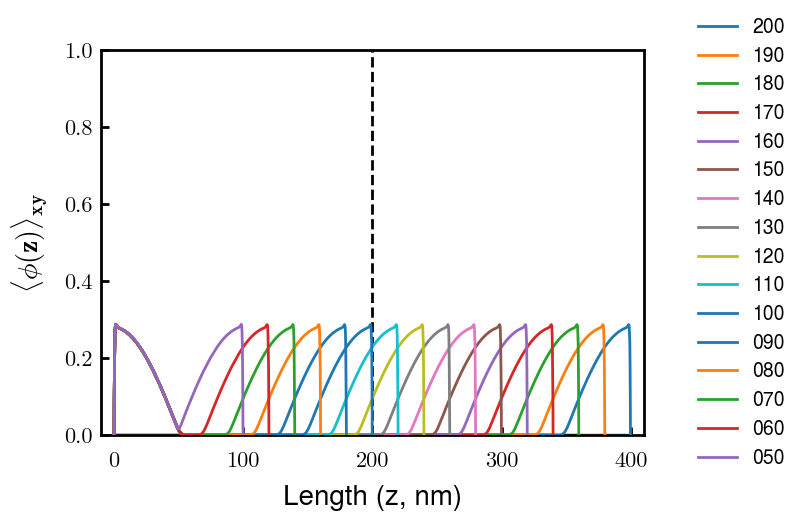

In [2]:
labs = ['{:03d}'.format(i) for i in np.arange(200, 49, -10)]
read_list = [GIT+'ph_a050d{}.dat'.format(i) for i in labs]
max_d = 200
# shifts = [max_d-float(i) for i in labs]
shifts = [0 for i in labs]
fig, ax = tjy.plot_pha(read_list, b0=1.0, x1_shift = shifts, x1_start = -10, x1_end=max_d*2+10, labs=labs, double=False, show=False)
plt.sca(ax)
plt.plot([200]*2,[0,1], '--', lw =2, color='k')
plt.legend(frameon=True, framealpha=1.0, facecolor='w', edgecolor='w', loc='center left', bbox_to_anchor=(1.05,0.5))
plt.show()

C:\Users\takas\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


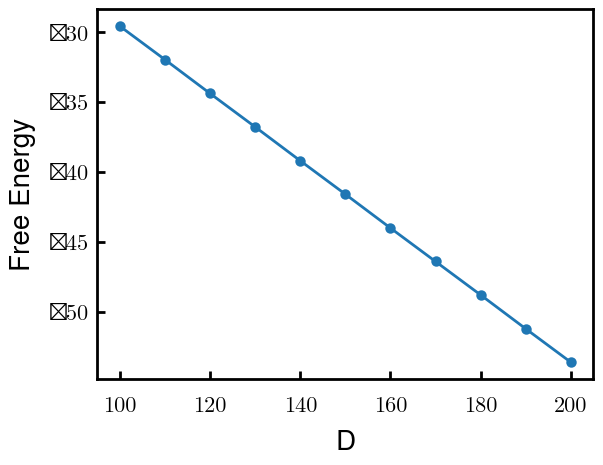

In [8]:
freeE = pd.read_csv(GIT+'c200_coll.txt', sep="\s+", skiprows=0, names = ['it', 'lx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='lx')
plt.figure()
cs = 6.022e-02 * 2;
plt.plot(freeE.lx/2, freeE.freeE+freeE.lx*cs, 'o-')
plt.xlabel('D')
plt.ylabel('Free Energy')
tjy.ticks()
plt.show()